In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
# from prettytable import PrettyTable

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [3]:
data = pd.read_csv('datasets/smoking_driking_dataset_Ver01.csv')

# data['sex'] = (data['sex'] == 'Female').astype(int)
data['DRK_YN'] = (data['DRK_YN'] == 'Y').astype(int)

y = data['DRK_YN']

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

In [79]:
scaler=StandardScaler()
numeric_features = [col for col in data.columns if data[col].dtype.name in ["int64", "float64"] \
                            and col != "sex"]
sex_feature = pd.get_dummies(data,columns=["sex"],prefix="sex")
scaler.fit_transform(sex_feature)

array([[-0.88951382,  0.83587354,  0.93620986, ...,  1.0003733 ,
        -0.9397885 ,  0.9397885 ],
       [-1.24209002,  1.91311698,  1.33575488, ..., -0.99962684,
        -0.9397885 ,  0.9397885 ],
       [-0.53693763,  0.29725182,  0.93620986, ..., -0.99962684,
        -0.9397885 ,  0.9397885 ],
       ...,
       [-0.53693763, -0.77999162, -1.0615152 , ...,  1.0003733 ,
         1.06406921, -1.06406921],
       [-1.59466621,  1.37449526, -0.26242517, ..., -0.99962684,
        -0.9397885 ,  0.9397885 ],
       [ 0.16821475, -0.2413699 ,  0.53666485, ...,  1.0003733 ,
        -0.9397885 ,  0.9397885 ]])

In [6]:
df_full, df_test, y_full, y_test = train_test_split(data,y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val  = train_test_split(df_full,y_full, test_size=0.25, random_state=1)

In [7]:
train_copy = df_train.copy()

table = PrettyTable()
table.field_names = ['field', 'dtype', 'n-uninque', 'original-missing-%', 'train-missing-%', 'val-missing-%']
for col in train_copy.columns:
    train_missing = (df_train[col].isna().sum()/len(df_train[col]))*100.0
    val_missing = (df_val[col].isna().sum()/len(df_val[col]))*100.0
    orignal_missing = (data[col].isna().sum()/len(data[col]))*100.0
    table.add_row([col,train_copy[col].dtype, train_copy[col].nunique(), orignal_missing, train_missing, val_missing])
print(table)

+------------------+---------+-----------+--------------------+-----------------+---------------+
|      field       |  dtype  | n-uninque | original-missing-% | train-missing-% | val-missing-% |
+------------------+---------+-----------+--------------------+-----------------+---------------+
|       sex        |  int64  |     2     |        0.0         |       0.0       |      0.0      |
|       age        |  int64  |     14    |        0.0         |       0.0       |      0.0      |
|      height      |  int64  |     13    |        0.0         |       0.0       |      0.0      |
|      weight      |  int64  |     24    |        0.0         |       0.0       |      0.0      |
|    waistline     | float64 |    703    |        0.0         |       0.0       |      0.0      |
|    sight_left    | float64 |     24    |        0.0         |       0.0       |      0.0      |
|   sight_right    | float64 |     24    |        0.0         |       0.0       |      0.0      |
|    hear_left     |

In [9]:
is_discrete = (train_copy.dtypes=='int').values

def make_mutual_info_score(X, y, discrete_features):
    table = PrettyTable()
    table.field_names = ['feild', 'MI-score']

    scores = mutual_info_classif(X=X, y=y, discrete_features=discrete_features)
    
    
    for col, score in zip(X.columns, scores):
        table.add_row([col, score])
        table.sortby = 'MI-score'
    print(table)
    
    return scores

In [10]:
mi_score = make_mutual_info_score(train_copy, y_train,is_discrete)

+------------------+-----------------------+
|      feild       |        MI-score       |
+------------------+-----------------------+
|    tot_chole     | 0.0009583227223157742 |
|    LDL_chole     | 0.0015873321920725214 |
|       BLDS       | 0.0018849150488076116 |
|    HDL_chole     |  0.003600092576639513 |
|       SBP        |  0.004147048601957692 |
|     SGOT_AST     |  0.004973388890762598 |
|   triglyceride   |  0.00674274528519736  |
|     SGOT_ALT     |  0.007564081821001878 |
|    waistline     |  0.009518477530015002 |
|       DBP        |  0.010317083971326468 |
|   sight_right    |  0.02220814189535769  |
|    sight_left    |  0.02285787158987751  |
| serum_creatinine |  0.028749727182549645 |
|      weight      |  0.03896399303916578  |
|       age        |  0.04442678076361187  |
|    gamma_GTP     |  0.04971594278741631  |
|    hemoglobin    |  0.05506713542013886  |
|    hear_right    |  0.06393068134336488  |
|    hear_left     |  0.06545375196655412  |
|       se

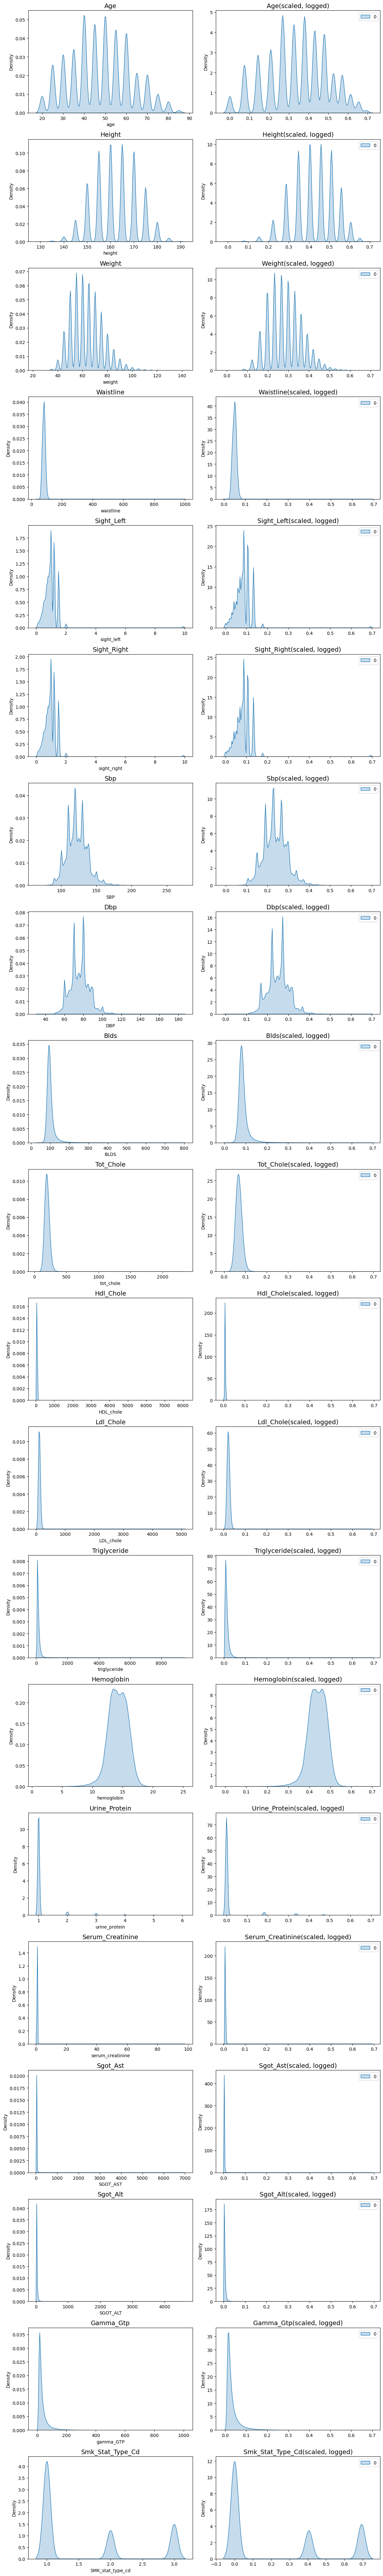

CPU times: user 1min 39s, sys: 7.52 s, total: 1min 46s
Wall time: 1min 31s


In [34]:
%%time
cols_to_plot = list(col for col in features if train_copy[col].nunique() > 2 )

fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(12, 4 * len(cols_to_plot)))

for i, col in enumerate(cols_to_plot):
    scaler= MinMaxScaler()
    scaled = scaler.fit_transform(train_copy[col])
    logged = np.log1p(scaled)
    sns.kdeplot(train_copy[col], fill=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col.title()}', fontsize=14)
    
    sns.kdeplot(logged, fill=True, ax=axes[i, 1])
    axes[i,1].set_title(f'{col.title()}(scaled, logged)', fontsize=14)

fig.tight_layout()
plt.show()

numerical transformation doesnt change the model by much so we will not be applying any

# Model Definition

In [ ]:
class Model:
    """
    This class implements a ml model pipeline for regression or classification.
    """

    def __init__(self, dataset, training_function, scaler=StandardScaler(), vectorizer=DictVectorizer(sparse=False)):
        
        self.dataset = dataset
        self.training_function = training_function
        self.vectorizer = vectorizer
        self.model = None
        self.predictions = None
        self.best_estimator = None
        self.target=None
        


        self.setup_data()
        self.Xtrain = self._prepare_dataset(self.train_data, train_data=True)
        self.Xval = self._prepare_dataset(self.val_data, train_data=False)
        self.Xfull = None
        self.Xtest = None

    def setup_data(self):
        print('intial data setup...')

        self.dataset['sex'] = (self.dataset['sex'] == 'Male').astype(int)
        self.dataset['DRK_YN'] = (self.dataset['DRK_YN'] == 'Y').astype(int)
        self.target = self.dataset['DRK_YN']
        del self.dataset['DRK_YN']

        self.dataset.columns = self.dataset.columns.str.lower().str.replace(" ", "_")


        self.train_test_data, self.test_data, self.y_full, self.y_test = train_test_split(self.dataset,self.target, test_size=0.2, random_state=1)
        self.train_data, self.val_data, self.y_train, self.y_val  = train_test_split(self.train_test_data,self.y_full, test_size=0.25, random_state=1)
        
    def _prepare_dataset(self, data, train_data=True):
        data_dict = data.to_dict(orient='records')
        # data_with_dummies = pd.get_dummies(data,columns=["sex"],prefix="sex", drop_first=True)
        
        if train_data:
            vectorized_data = self.vectorizer.fit_transform(data_dict)
            # scaled_data = self.scaler.fit_transform(data_with_dummies)
        else:
            vectorized_data = self.vectorizer.transform(data_dict)
            # scaled_data = self.scaler.transform(data_with_dummies)
        
        return vectorized_data


    def train(self, use_full_train=False):
        if use_full_train:
            print("Training with full data...")
            self.Xfull = self._prepare_dataset(self.train_test_data, train_data=True)
            self.Xtest = self._prepare_dataset(self.test_data, train_data=False)
            self.training_function.fit(self.Xfull, self.y_full)
        else:
            print("Training with split data...")
            self.training_function.fit(self.Xtrain, self.y_train)

    def predict(self, use_full_train=False):
        print("Predicting...")
        if not use_full_train:
            self.predictions = self.training_function.predict(self.Xval)
        else:
            self.predictions = self.training_function.predict(self.Xtest)

    def score_model(self, use_full_train=False):
        print("Scoring...")
        if use_full_train:
            score = accuracy_score(self.y_test, self.predictions)
        else:
            score = accuracy_score(self.y_val, self.predictions)
        return score

    def tune_random_search(self, params, scoring="roc_auc", cv=5, use_full_train=False):
        print("Tuning hyperparameters...")
        random_search = RandomizedSearchCV(
            self.training_function, params, scoring=scoring, verbose=1, cv=cv, n_jobs=-1
        )
        if use_full_train:
            self.Xfull = self._prepare_dataset(self.train_test_data,train_data=True)
            self.Xtest = self._prepare_dataset(self.test_data, train_data=False)
            random_search.fit(self.Xfull, self.y_full)
        else:
            random_search.fit(self.Xtrain, self.y_train)
            
        self.training_function = random_search.best_estimator_
        print(f"Updated training function: {self.training_function}")

In [5]:
del data['DRK_YN']

# Logistic Regression

In [7]:
dv = DictVectorizer(sparse=False)

In [96]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

logistic_model = Model(dataset=data, target=y, training_function=lr)
logistic_model.train()
logistic_model.predict()
logistic_accuracy = logistic_model.score_model()
logistic_accuracy

Training with split data...
Predicting...
Scoring...


0.7259077314154003

# RandomForestClassifier

In [102]:
%%time
rf = RandomForestClassifier(random_state=1)
rf_params = {
    'n_estimators': np.arange(150,210, 10),
    'max_depth': np.arange(3, 7),
    'min_samples_leaf':np.arange(1,4)
}


rf_model = Model(dataset=data, target=y, training_function=rf)
rf_model.tune_random_search(params=rf_params, cv=2)
rf_model.train()
rf_model.predict()
rf_accuracy = rf_model.score_model()
rf_accuracy

Tuning hyperparameters...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Updated training function: RandomForestClassifier(max_depth=6, n_estimators=180, random_state=1)
Training with split data...
Predicting...
Scoring...
CPU times: user 2min 47s, sys: 2.31 s, total: 2min 49s
Wall time: 8min 6s


0.7112458326818615

# XGBClassifier

In [6]:
%%time
xgbclf = XGBClassifier()

xgb_params = {
    'n_estimators': np.arange(10, 250, 20),
    'max_depth': np.arange(3, 20, 2),
    'learning_rate': np.arange(0.1,0.6, 0.1)
    }


xgb_model = Model(dataset=data, target=y, training_function=xgbclf)
xgb_model.tune_random_search(params=xgb_params, cv=2)
xgb_model.train()
xgb_model.predict()
xgb_accuracy = xgb_model.score_model()
xgb_accuracy

Tuning hyperparameters...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Updated training function: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training with split data...
Predicting...
Scoring...
CPU times: user 27.1 s, sys: 969 ms, total: 28 s
Wall time: 2min 53s


0.7380881529639026

In [7]:
xgb_model.model.save_model(f'xbg-clf-model-{xgb_accuracy:.3f}.json')

selected the xgboost model for the highest accuracy score